In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

C:\Users\shubh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\shubh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\shubh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\shubh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
output = []
env = gym.make('MsPacman-ram-v0')
env.reset()
for _ in range(1000):
    output.append(env.render(mode = 'rgb_array'))
    env.step(env.action_space.sample()) # take a random action
env.close()

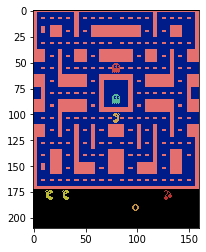

In [3]:
plt.imshow(output[2])

In [10]:
from collections import deque 
import random
class DQN:

  """ Deep Q Network """

  def __init__(self, env, params):

      self.action_space = env.action_space.n
      self.state_space = env.observation_space.shape[0]
      self.epsilon = params['epsilon']                  # epsilon greedy exploration
      self.gamma = params['gamma']                      # discount factor
      self.batch_size = params['batch_size']            # experience replay batch size
      self.epsilon_min = params['epsilon_min']          # min greedininess
      self.epsilon_decay = params['epsilon_decay']      # decay factor for exploration
      self.learning_rate = params['learning_rate']      # NN learning rate
      self.layer_sizes = params['layer_sizes']          # NN architecture
      self.memory = deque(maxlen=2500)                  # maximum memory for experinece replay
      self.model = self.build_model()                   


  def build_model(self):
      model = Sequential()
      for i in range(len(self.layer_sizes)):
          if i == 0:
              model.add(Dense(self.layer_sizes[i], input_shape=(self.state_space,), activation='relu'))
          else:
              model.add(Dense(self.layer_sizes[i], activation='relu'))
      model.add(Dense(self.action_space, activation='softmax'))
      model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
      return model


  def remember(self, state, action, reward, next_state, done):
    # create dataet for xperience replay
      self.memory.append((state, action, reward, next_state, done))


  def act(self, state):
      #  epsilon greedy policy
      if np.random.rand() <= self.epsilon:
          return random.randrange(self.action_space)
      act_values = self.model.predict(state)
      return np.argmax(act_values[0])


  def exp_replay(self):
    if len(self.memory)<self.batch_size:
      return
    minibatch = random.sample(self.memory, self.batch_size)
    states = np.array([i[0] for i in minibatch])
    actions = np.array([i[1] for i in minibatch])
    rewards = np.array([i[2] for i in minibatch])
    next_states = np.array([i[3] for i in minibatch])
    dones = np.array([i[4] for i in minibatch])
    
    states = np.squeeze(states)
    next_states = np.squeeze(next_states)

    targets_pred = self.model.predict_on_batch(states)
    targets_act = rewards + self.gamma*((np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones))

    ind = np.array([i for i in range(self.batch_size)])
    targets_full = targets_pred
    targets_full[[ind], [actions]] = targets_act

    self.model.fit(states, targets_full, epochs=1, verbose=0)
    if self.epsilon > self.epsilon_min:
        self.epsilon *= self.epsilon_decay


def learning(env,episodes, params):

  sum_of_rewards = []
  output = []
  agent = DQN(env, params)
  for ep in range(episodes):
      state = env.reset()
      state = np.reshape(state, (1, env.observation_space.shape[0]))
      score = 0
      tot_reward = 0
      max_steps = 100000
      while True:
          action = agent.act(state)
          next_state, reward, done, _ = env.step(action)
          points = reward
          reward -=1
          if done == True:
                reward = -1000
#           env.render(mode = 'human')
          tot_reward += reward
          score += points
          next_state = np.reshape(state, (1, env.observation_space.shape[0]))
          agent.remember(state, action, reward, next_state, done)
          if params['batch_size'] > 1:
              agent.exp_replay()
          if done:
#               print(f'final state before dying: {str(state)}')
              print(f'episode: {ep+1}/{episodes}, score: {score}, rewards : {tot_reward}')
              print(agent.epsilon)
              break
          state = next_state
      sum_of_rewards.append(score)
      agent.model.save('model')
      agent.model.save_weights('weights')
  env.close()
  return sum_of_rewards, output


params = dict()
params['name'] = None
params['epsilon'] = 1
params['gamma'] = 0.8
params['batch_size'] = 512
params['epsilon_min'] = 0.01
params['epsilon_decay'] = .99999
params['learning_rate'] = 0.01
params['layer_sizes'] = [64, 32, 16]

results = dict()
ep = 2000


# env_infos = {'States: only walls':{'state_space':'no body knowledge'}, 'States: direction 0 or 1':{'state_space':''}, 'States: coordinates':{'state_space':'coordinates'}, 'States: no direction':{'state_space':'no direction'}}

env = gym.make('MsPacman-ram-v0')
sum_of_rewards, output = learning(env, ep, params)

episode: 1/2000, score: 280.0, rewards : -1505.0
0.9972537640739171
episode: 2/2000, score: 210.0, rewards : -1402.0
0.9911592667463877
episode: 3/2000, score: 610.0, rewards : -1259.0
0.9825735402619077
episode: 4/2000, score: 580.0, rewards : -1350.0
0.9734681862663941
episode: 5/2000, score: 190.0, rewards : -1449.0
0.967257853086803
episode: 6/2000, score: 240.0, rewards : -1472.0
0.9603857982225352
episode: 7/2000, score: 230.0, rewards : -1431.0
0.9540490104640773
episode: 8/2000, score: 180.0, rewards : -1531.0
0.9472802729662283
episode: 9/2000, score: 180.0, rewards : -1386.0
0.9419243653858843
episode: 10/2000, score: 290.0, rewards : -1466.0
0.9348208830253738
episode: 11/2000, score: 260.0, rewards : -1418.0
0.9284949185536767
episode: 12/2000, score: 220.0, rewards : -1517.0
0.9216678149179246
episode: 13/2000, score: 260.0, rewards : -1486.0
0.9148085732081574
episode: 14/2000, score: 160.0, rewards : -1484.0
0.9089270169129214
episode: 15/2000, score: 200.0, rewards : -1

episode: 120/2000, score: 230.0, rewards : -1560.0
0.4017864464799884
episode: 121/2000, score: 260.0, rewards : -1391.0
0.39917530735686185
episode: 122/2000, score: 200.0, rewards : -1529.0
0.3962719233413801
episode: 123/2000, score: 250.0, rewards : -1489.0
0.3933503197661591
episode: 124/2000, score: 330.0, rewards : -1346.0
0.39069631876148464
episode: 125/2000, score: 290.0, rewards : -1624.0
0.38713773500047527
episode: 126/2000, score: 250.0, rewards : -1657.0
0.3836384178123683
episode: 127/2000, score: 320.0, rewards : -1380.0
0.3809585031790283
episode: 128/2000, score: 230.0, rewards : -1460.0
0.37833514096013054
episode: 129/2000, score: 260.0, rewards : -1345.0
0.3760493515142094
episode: 130/2000, score: 360.0, rewards : -1615.0
0.37239694432187415
episode: 131/2000, score: 180.0, rewards : -1567.0
0.3696217933066643
episode: 132/2000, score: 330.0, rewards : -1311.0
0.3672564105697136
episode: 133/2000, score: 250.0, rewards : -1518.0
0.3644430260334791
episode: 134/20

episode: 237/2000, score: 250.0, rewards : -1386.0
0.1621782734674046
episode: 238/2000, score: 180.0, rewards : -1520.0
0.16104537355932577
episode: 239/2000, score: 240.0, rewards : -1591.0
0.1597110279545419
episode: 240/2000, score: 300.0, rewards : -1375.0
0.15863501704001162
episode: 241/2000, score: 300.0, rewards : -1454.0
0.15744182665702489
episode: 242/2000, score: 350.0, rewards : -1611.0
0.15593449065871606
episode: 243/2000, score: 190.0, rewards : -1553.0
0.15477863737490197
episode: 244/2000, score: 260.0, rewards : -1415.0
0.15373585714059765
episode: 245/2000, score: 180.0, rewards : -1514.0
0.1526710919545817
episode: 246/2000, score: 270.0, rewards : -1539.0
0.15143944485631403
episode: 247/2000, score: 540.0, rewards : -1356.0
0.15008710060579267
episode: 248/2000, score: 220.0, rewards : -1696.0
0.14871708615968068
episode: 249/2000, score: 240.0, rewards : -1552.0
0.14754241751005034
episode: 250/2000, score: 210.0, rewards : -1400.0
0.14664367729272393
episode: 

episode: 353/2000, score: 240.0, rewards : -1576.0
0.06494960154185997
episode: 354/2000, score: 240.0, rewards : -1462.0
0.06449460475560917
episode: 355/2000, score: 290.0, rewards : -1511.0
0.06397942408544767
episode: 356/2000, score: 230.0, rewards : -1467.0
0.06353440041962348
episode: 357/2000, score: 250.0, rewards : -1513.0
0.06305084471750799
episode: 358/2000, score: 240.0, rewards : -1618.0
0.06251155483110576
episode: 359/2000, score: 300.0, rewards : -1437.0
0.062051915413876904
episode: 360/2000, score: 260.0, rewards : -1575.0
0.06153532119062214
episode: 361/2000, score: 240.0, rewards : -1447.0
0.061113409113068694
episode: 362/2000, score: 180.0, rewards : -1612.0
0.06063069386083406
episode: 363/2000, score: 300.0, rewards : -1416.0
0.06019752438830011
episode: 364/2000, score: 300.0, rewards : -1336.0
0.059815282978149246
episode: 365/2000, score: 240.0, rewards : -1352.0
0.059461626210483086
episode: 366/2000, score: 300.0, rewards : -1415.0
0.05903739939005842
ep

episode: 469/2000, score: 240.0, rewards : -1457.0
0.027142947329850023
episode: 470/2000, score: 180.0, rewards : -1475.0
0.02696547146527684
episode: 471/2000, score: 240.0, rewards : -1492.0
0.026768536224181128
episode: 472/2000, score: 230.0, rewards : -1537.0
0.026563740265098862
episode: 473/2000, score: 230.0, rewards : -1558.0
0.026354975968739723
episode: 474/2000, score: 190.0, rewards : -1535.0
0.026164330769427813
episode: 475/2000, score: 220.0, rewards : -1365.0
0.026011455389081117
episode: 476/2000, score: 160.0, rewards : -1622.0
0.025808579972771518
episode: 477/2000, score: 190.0, rewards : -1544.0
0.025619581385637222
episode: 478/2000, score: 220.0, rewards : -1536.0
0.025426372407141448
episode: 479/2000, score: 190.0, rewards : -1479.0
0.025256584288421854
episode: 480/2000, score: 240.0, rewards : -1382.0
0.02509972411080883
episode: 481/2000, score: 240.0, rewards : -1462.0
0.024923890948863398
episode: 482/2000, score: 240.0, rewards : -1609.0
0.0247129346554

episode: 584/2000, score: 240.0, rewards : -1604.0
0.011617156366715701
episode: 585/2000, score: 170.0, rewards : -1557.0
0.011532890148235957
episode: 586/2000, score: 220.0, rewards : -1410.0
0.011460346365019379
episode: 587/2000, score: 170.0, rewards : -1620.0
0.01137005215818534
episode: 588/2000, score: 140.0, rewards : -1622.0
0.011283628354190136
episode: 589/2000, score: 230.0, rewards : -1456.0
0.011206375109868646
episode: 590/2000, score: 230.0, rewards : -1434.0
0.011132099583856078
episode: 591/2000, score: 240.0, rewards : -1533.0
0.011046269295632925
episode: 592/2000, score: 170.0, rewards : -1615.0
0.010959785513061746
episode: 593/2000, score: 240.0, rewards : -1519.0
0.010876806448121123
episode: 594/2000, score: 140.0, rewards : -1592.0
0.010797370547919242
episode: 595/2000, score: 70.0, rewards : -1628.0
0.010722159719814424
episode: 596/2000, score: 140.0, rewards : -1591.0
0.010643959680987258
episode: 597/2000, score: 170.0, rewards : -1603.0
0.0105618930303

episode: 698/2000, score: 140.0, rewards : -1571.0
0.009999971601096055
episode: 699/2000, score: 240.0, rewards : -1656.0
0.009999971601096055
episode: 700/2000, score: 140.0, rewards : -1591.0
0.009999971601096055
episode: 701/2000, score: 140.0, rewards : -1470.0
0.009999971601096055
episode: 702/2000, score: 170.0, rewards : -1450.0
0.009999971601096055
episode: 703/2000, score: 240.0, rewards : -1622.0
0.009999971601096055
episode: 704/2000, score: 170.0, rewards : -1624.0
0.009999971601096055
episode: 705/2000, score: 240.0, rewards : -1481.0
0.009999971601096055
episode: 706/2000, score: 240.0, rewards : -1601.0
0.009999971601096055
episode: 707/2000, score: 100.0, rewards : -1577.0
0.009999971601096055
episode: 708/2000, score: 170.0, rewards : -1499.0
0.009999971601096055
episode: 709/2000, score: 120.0, rewards : -1565.0
0.009999971601096055
episode: 710/2000, score: 240.0, rewards : -1607.0
0.009999971601096055
episode: 711/2000, score: 150.0, rewards : -1504.0
0.00999997160

episode: 812/2000, score: 210.0, rewards : -1533.0
0.009999971601096055
episode: 813/2000, score: 140.0, rewards : -1460.0
0.009999971601096055
episode: 814/2000, score: 240.0, rewards : -1554.0
0.009999971601096055
episode: 815/2000, score: 140.0, rewards : -1479.0
0.009999971601096055
episode: 816/2000, score: 210.0, rewards : -1542.0
0.009999971601096055
episode: 817/2000, score: 210.0, rewards : -1462.0
0.009999971601096055
episode: 818/2000, score: 200.0, rewards : -1575.0
0.009999971601096055
episode: 819/2000, score: 240.0, rewards : -1546.0
0.009999971601096055
episode: 820/2000, score: 170.0, rewards : -1716.0
0.009999971601096055
episode: 821/2000, score: 240.0, rewards : -1485.0
0.009999971601096055
episode: 822/2000, score: 120.0, rewards : -1525.0
0.009999971601096055
episode: 823/2000, score: 240.0, rewards : -1646.0
0.009999971601096055
episode: 824/2000, score: 240.0, rewards : -1461.0
0.009999971601096055
episode: 825/2000, score: 240.0, rewards : -1625.0
0.00999997160

KeyboardInterrupt: 

In [46]:
env = gym.make('MsPacman-ram-v0')

env.action_space.n

9